In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from highlight_text import fig_text, ax_text
from pyfonts import load_font

In [3]:
care_state = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-04-08/care_state.csv")

In [4]:
measure_list = ["OP_18b", "OP_18c"]

In [5]:
er = care_state[care_state["measure_id"].isin(measure_list)]

In [6]:
er = er[["state", "measure_id", "score"]]

In [7]:
er.head(2)

,state,measure_id,score
2,AK,OP_18b,140.0
7,AK,OP_18c,196.0


In [8]:
er = pd.pivot(er, index="state", columns="measure_id", values="score").dropna(subset=["OP_18b", "OP_18c"]).reset_index()

In [9]:
er.head(2)

measure_id,state,OP_18b,OP_18c
0,AK,140.0,196.0
1,AL,145.0,226.0


In [10]:
tables = pd.read_html("https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States")

In [11]:
us = tables[1]
us.columns = us.columns.get_level_values(1)
us.rename(columns={"Flag, name and postal abbreviation[8]": "name", "Flag, name and postal abbreviation[8].1": 'abbreviation', "Population (2020)[10]": "population"}, inplace=True)
us = us[["name", "abbreviation", "population"]]

In [12]:
dc = tables[2]
dc.columns = dc.columns.get_level_values(1)
dc.rename(columns={"Flag, name and postal abbreviation[8]": "name", "Flag, name and postal abbreviation[8].1": 'abbreviation', "Population (2020) [10]": "population"}, inplace=True)
dc = dc[["name", "abbreviation", "population"]]

In [13]:
territories = tables[3]
territories.columns = territories.columns.get_level_values(1)
territories.rename(columns={"Name and postal abbreviation[8]": "name", "Name and postal abbreviation[8].1": 'abbreviation', "Population (2020) [10][17]": "population"}, inplace=True)
territories = territories[["name", "abbreviation", "population"]]

In [14]:
wiki = pd.concat([us, dc, territories], axis=0)

In [15]:
wiki['name'] = wiki['name'].str.replace(r'\[.\]', '', regex=True)

In [16]:
wiki.head(2)

,name,abbreviation,population
0,Alabama,AL,5024279
1,Alaska,AK,733391


In [17]:
df = er.merge(wiki, left_on='state', right_on='abbreviation')

In [18]:
df = df[["name", "abbreviation", "population", "OP_18b", "OP_18c"]].dropna(subset=["OP_18b", "OP_18c"])

In [19]:
bins = [0, 2000000, 5000000, 10000000, 40000000] 
lab = ['Small', 'Moderate', 'Big', 'Very big']
df["group"] = pd.cut(df["population"], bins=bins, labels=lab, include_lowest=True)

In [20]:
df.head(2)

,name,abbreviation,population,OP_18b,OP_18c,group
0,Alaska,AK,733391,140.0,196.0,Small
1,Alabama,AL,5024279,145.0,226.0,Big


In [21]:
pop = df.group.value_counts().reset_index()

In [22]:
# Sort the DataFrame first by the desired columns
df_sorted = df.sort_values(["OP_18c", "OP_18b"], ascending=False)

# Now perform the groupby and reset the index within each group
df_sorted_grouped = df_sorted.groupby(["group"], observed=True) \
                            .apply(lambda group: group.reset_index(drop=True))

df_final = df_sorted_grouped.reset_index(drop=True)

/tmp/ipykernel_1315755/2520932522.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.reset_index(drop=True))


In [23]:
b_median = df_final["OP_18b"].median().astype(int)
c_median = df_final["OP_18c"].median().astype(int)

In [24]:
print(b_median, c_median)

154 254


In [25]:
b_more = df_final[df_final["OP_18b"]>b_median].groupby("group", observed=True).size().reset_index()
b_more.columns = ["group", "b_more_count"]
c_more = df_final[df_final["OP_18c"]>c_median].groupby("group", observed=True).size().reset_index()
c_more.columns = ["group", "c_more_count"]

pd_list = [pop, b_more, c_more]
tab = pd.concat(pd_list, axis=1)
tab["b_perc"] = (tab["b_more_count"] / tab["count"]*100).round(1)
tab["c_perc"] = (tab["c_more_count"] / tab["count"]*100).round(1)

In [26]:
tab

,group,count,group,b_more_count,group,c_more_count,b_perc,c_perc
0,Small,15,Small,6,Small,7,40.0,46.7
1,Big,14,Moderate,3,Moderate,4,21.4,28.6
2,Moderate,13,Big,8,Big,8,61.5,61.5
3,Very big,10,Very big,9,Very big,7,90.0,70.0


In [27]:
df_final["op18c"] = df_final["OP_18c"] - df_final["OP_18b"]

In [28]:
cabin_bold = load_font(
    font_url="https://github.com/impallari/Cabin/blob/master/fonts/TTF/Cabin-Bold.ttf?raw=true"
)

garamond = load_font(
    font_url="https://github.com/octaviopardo/EBGaramond12/blob/master/fonts/ttf/EBGaramond-Regular.ttf?raw=true"
)

garamond_bold = load_font(
    font_url="https://github.com/octaviopardo/EBGaramond12/blob/master/fonts/ttf/EBGaramond-Bold.ttf?raw=true"
)

In [29]:
categories = df_final["group"].unique()  
names = df_final["name"].unique()       
values1 = df_final["OP_18b"].values       
values2 = df_final["OP_18c"].values 

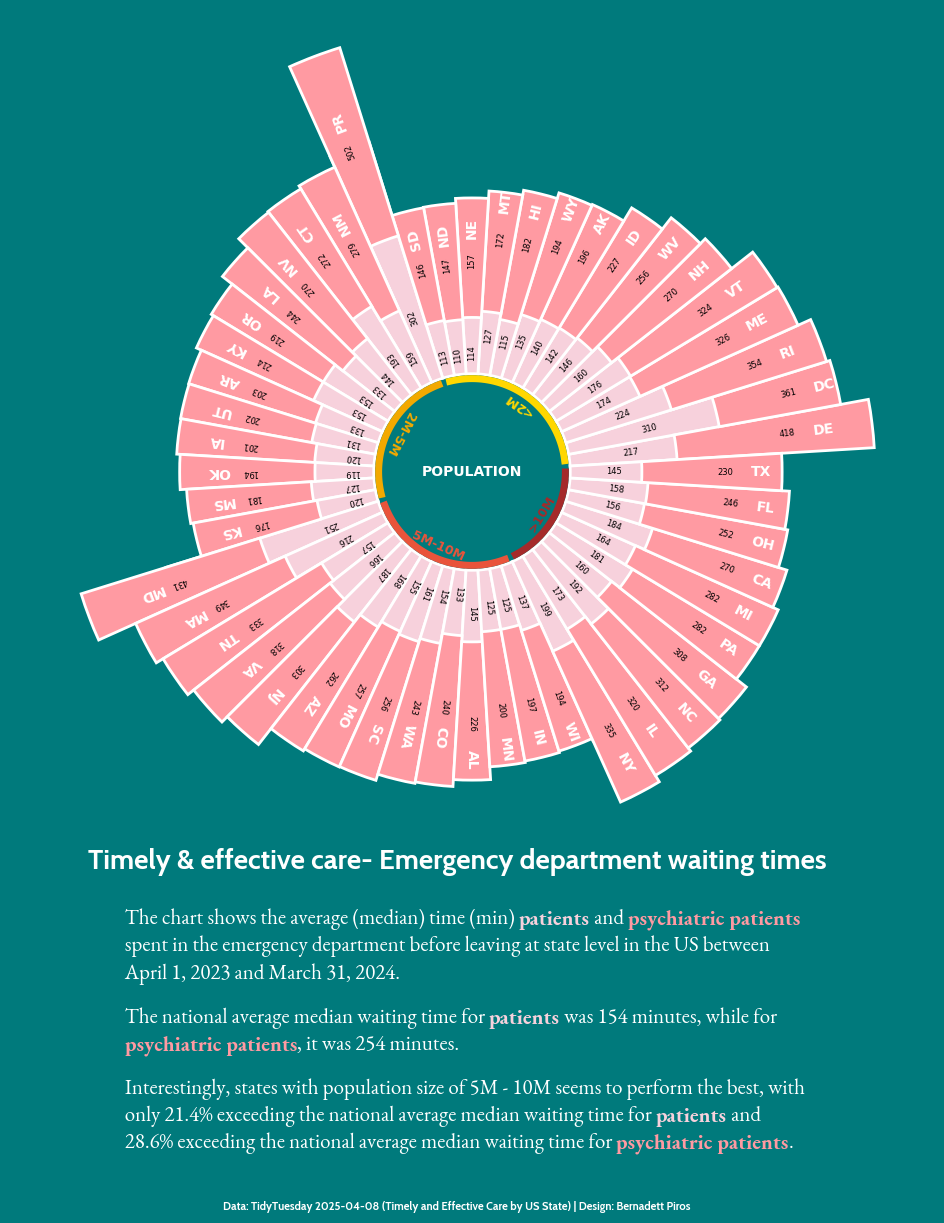

In [30]:
fig, ax = plt.subplots(subplot_kw=dict(polar=True), figsize=(12, 12))
plt.axis('off')  

upperLimit = 500
lowerLimit = 100
max_value = df_final["op18c"].max()
slope = (max_value - lowerLimit) / max_value

heights = slope * df_final["OP_18b"] + lowerLimit
heights2 = slope * df_final["op18c"] + lowerLimit

width = 2 * np.pi / len(df_final)
indexes = list(range(1, len(df_final.index) + 1))
angles = [element * width for element in indexes]

bars1 = ax.bar(
    x=angles,
    height=heights,
    width=width,
    bottom=lowerLimit,
    linewidth=2,
    edgecolor="white",
    color='#F7D1DC',  
)

bars2 = ax.bar(
    x=angles,
    height=heights2,
    width=width,
    bottom=heights,    
    linewidth=2,
    edgecolor="white",
    color='#FF9AA2',  
)

for bar1, bar2, angle, height1, height2, label1, label2, name in zip(bars1, bars2, angles, heights, heights2, df_final["OP_18b"], df_final["OP_18c"], df_final["abbreviation"]):
    rotation = np.rad2deg(angle)
    alignment = "left" if angle < np.pi / 2 or angle >= 3 * np.pi / 2 else "right"    
    
    ax.text(
        x=angle,
        y=lowerLimit + bar1.get_height() / 2 -50,  
        s=str(int(label1)),
        ha=alignment,
        va='center',
        rotation=rotation,
        rotation_mode="anchor",
        fontsize=6,
        color="black",
    )

    ax.text(
        x=angle,
        y=lowerLimit + bar1.get_height() + bar2.get_height() / 2 -95,  
        s=str(int(label2)),
        ha=alignment,
        va='center',
        rotation=rotation,
        rotation_mode="anchor",
        fontsize=6,
        color="black",
    )   

    ax.text(
        x=angle,
        y=lowerLimit + bar1.get_height() + bar2.get_height() / 2 -60,  
        s=name,
        ha=alignment,
        va='center',
        rotation=rotation,
        rotation_mode="anchor",        
        weight="bold",
        color="white",
    )   

cat_labels = ["<2M", "2M-5M", "5M-10M", ">10M"]
category_sizes = df_final.groupby("group", observed=True).size().values
colors = ["#FFD700", "#F2A900", "#E9543B", "#A52A2A"]

offset = 0
radius = lowerLimit - 17
for i, (cat_label, size) in enumerate(zip(cat_labels, category_sizes)):
    start = offset 
    end = offset + size - 1        
    
    arc_angles = angles[start:end+1]
    arc_center_angle = np.mean(arc_angles)
    
    ax.plot(
        np.linspace(angles[start], angles[end], 50),
        [lowerLimit-5] * 50,
        color=colors[i],
        linewidth=5
    )    
    
    ax.text(
        arc_center_angle,
        radius,        
        cat_labels[i],
        color=colors[i],
        fontsize=9,
        fontweight="bold",
        ha="center",
        va="center",
        rotation=np.degrees(arc_center_angle + np.pi / 2),
        rotation_mode="anchor"
    )

    offset += size

ax.text(
    0, 0,  
    "POPULATION",
    ha="center",
    va="center",
    #fontsize=8,
    color="white",
    fontweight="bold"
)

fig.text(0.5, 0.17, "Timely & effective care- Emergency department waiting times",
         font=cabin_bold, color="white", size=20, ha="center", va="center")

txt = '''
      The chart shows the average (median) time (min) <patients> and <psychiatric patients>
      spent in the emergency department before leaving at state level in the US between
      April 1, 2023 and March 31, 2024.\n\n

      The national average median waiting time for <patients> was 154 minutes, while for
      <psychiatric patients>, it was 254 minutes.\n\n

      Interestingly, states with population size of 5M - 10M seems to perform the best, with
      only 21.4% exceeding the national average median waiting time for <patients> and
      28.6% exceeding the national average median waiting time for <psychiatric patients>.     
      '''

fig_text(0.5, 0.02,
         s=txt,
         font=garamond, color="white", size=15, ha="center", va="center", 
         highlight_textprops=[
             {"color": "#F7D1DC", "font": garamond_bold},
             {"color": "#FF9AA2", "font": garamond_bold},
             {"color": "#F7D1DC", "font": garamond_bold},
             {"color": "#FF9AA2", "font": garamond_bold},
             {"color": "#F7D1DC", "font": garamond_bold},
             {"color": "#FF9AA2", "font": garamond_bold},
             ])

fig.text(0.5, -0.12, "Data: TidyTuesday 2025-04-08 (Timely and Effective Care by US State) | Design: Bernadett Piros", ha="center", color="white", font=cabin_bold, size=8)

fig.set_facecolor("#007A7C")

plt.show()

#fig.savefig("2025-04-08.png", bbox_inches='tight', pad_inches=0.2)

I got a bit creative with this stacked circular bar chart — I used the difference between the two measures for the outer ring to cut down on distortion, but still labeled it with the real values. I did it to look the plot cleaner while keeping the data honest.

This week #TidyTuesday data explores state-level results for MEDICARE timely and effective care measurements. I took some liberty with my stacked circular bar chart — I used the difference between the two measures for the outer ring to cut down on distortion, but still labeled it with the real values. I did it to look the plot cleaner while keeping the data honest.
#pydytuesday #tidytuesday #dataviz